# Note to Reviewer: 
Several feature engineering steps were completed throughout my data preprocessing and EDA steps. 
I've completed troubleshooting for previous open questions:
- why do all zctas have at least one flood? I made the choice early on to only include zctas with floods, but went back and added all. ZCTAs with no floods could add value to model.
- I added a new dataset, National hydrography dataset (ie streamlines) and calculated total channel lenght within each zcta.
- I also added a count of flood by season (fall, winter, and spring) to use in the model 

In [26]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error

from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor
from sklearn import tree
from sklearn.preprocessing import FunctionTransformer

from scipy import stats

In [27]:
data = pd.read_csv('data/02_data.csv', index_col=0)

data.isna().sum()


med_houseinc_12mon              0
household_public_assistance1    0
gini                            0
total_population                0
state_fips                      0
nflood_total                    0
flood_count_fall                0
flood_count_winter              0
flood_count_spring              0
nflood_2000s                    0
nflood_2010s                    0
flood_dur_hours_median          0
flood_dur_hours_min             0
flood_dur_hours_max             0
zcta                            0
channel_length_km               0
delta_floods                    0
dtype: int64

In [28]:
target = 'med_houseinc_12mon'

In [29]:
# keep zcta but remove from modeling data
data.index = data['zcta']

# drop columns not used in model
data_medianinc = data.drop(['zcta', 'household_public_assistance1', 'gini'], axis=1)

data_medianinc


,med_houseinc_12mon,total_population,state_fips,nflood_total,flood_count_fall,flood_count_winter,flood_count_spring,nflood_2000s,nflood_2010s,flood_dur_hours_median,flood_dur_hours_min,flood_dur_hours_max,channel_length_km,delta_floods
zcta,,,,,,,,,,,,,,
35004,76683.0,11737.0,1,1,0,0,0,1.0,0.0,1.967213,1.967213,1.967213,64.301,-1.000000
35005,55017.0,8194.0,1,3,1,0,0,2.0,1.0,3.442623,1.967213,3.934426,94.617,-0.333333
35006,63521.0,3391.0,1,2,0,1,0,0.0,1.0,3.196721,1.967213,4.426230,306.497,1.000000
35007,81351.0,27052.0,1,6,1,0,1,1.0,4.0,2.459016,0.983607,8.852459,108.522,0.600000
35010,46730.0,20406.0,1,5,0,0,1,2.0,2.0,1.721311,0.983607,8.360656,649.526,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99919,64135.0,564.0,0,0,0,0,0,0.0,0.0,0.000000,0.000000,0.000000,0.000,0.000000
99921,59219.0,1727.0,0,0,0,0,0,0.0,0.0,0.000000,0.000000,0.000000,0.000,0.000000
99922,53125.0,328.0,0,0,0,0,0,0.0,0.0,0.000000,0.000000,0.000000,0.000,0.000000


### Scale Data
I'll scale data later for each individual model. Planning on starting with RFR which doesn't need scaling (if fact, prefer not to for optimal interpretability). 

### Categorical data have already been removed in step 2 EDA. 

### split test/train
Split data using 80/20 train/test split for now. Planning to complete cross-validation check after first model built to check variances. 

In [30]:
# split test/train data
X = data_medianinc.drop(target, axis=1)
y = data_medianinc[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=777)

# y_train = np.log(y_train)
y_train

zcta
67661     57841.0
21701     97769.0
46760     59563.0
30817     48684.0
92629    119368.0
           ...   
67554     62446.0
59808     72702.0
1094      87188.0
71855     42232.0
77859     49817.0
Name: med_houseinc_12mon, Length: 24280, dtype: float64

In [31]:
rfr = RandomForestRegressor(max_depth=5, n_estimators=100, random_state=777)

rfr.fit(X_train, y_train)
print('training model score: ', rfr.score(X_train, y_train))
print('test model score: ', rfr.score(X_test, y_test))
##bad scores, but similarly bad

training model score:  0.1694528400954428
test model score:  0.16725370801892447


#### Remove Correlated Features
I know that several features are highly correlated so let's review feature importance to select one of each grouping which has the highest model importance

- nflood_2000s, nflood_2010s, nflood_total, and delta_floods
    - nflood_total is most important, but will also try delta_floods as a close second
- flood_dur_hours median, max, min all highly correlated. Will keep median to start

<Axes: >

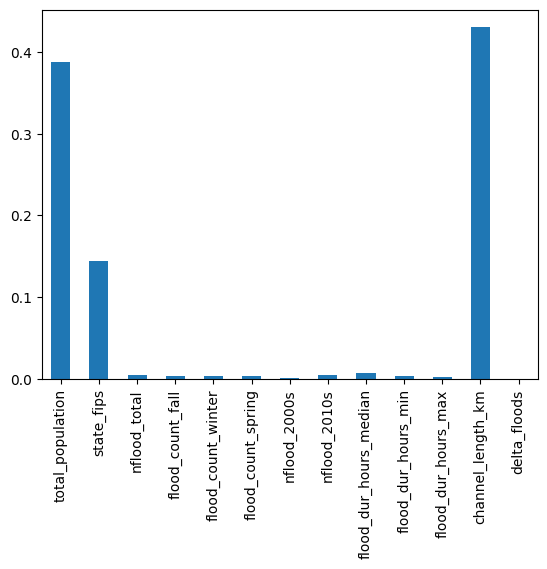

In [32]:
#next, we'll take a look at feature importance
importances = rfr.feature_importances_
forest_importances = pd.Series(importances, index=X_train.columns)

fig, ax = plt.subplots()
forest_importances.plot.bar(ax=ax)


training model score:  0.16765248256691512
test model score:  0.1674485353876537


<Axes: >

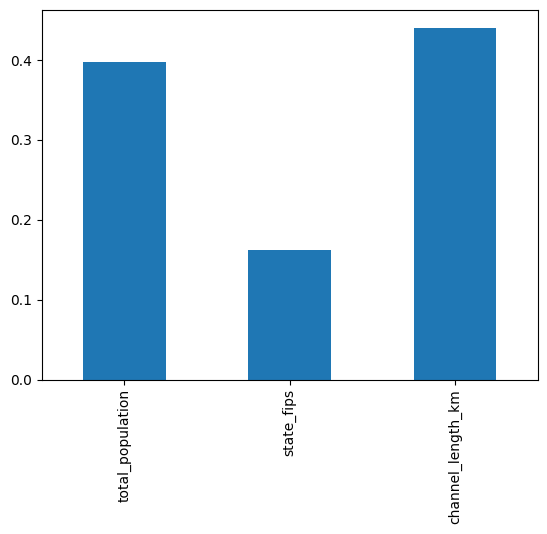

In [33]:
##remove feature to speed up model optimization. 

features_to_drop = ['nflood_2000s', 'flood_dur_hours_max', 'delta_floods', 'flood_count_spring', 'flood_count_fall', 'flood_dur_hours_min' ,
                   'nflood_2010s', 'flood_count_winter', 'flood_dur_hours_median', 'nflood_total']

X_train_fewer = X_train.drop(features_to_drop, axis=1)
X_test_fewer = X_test.drop(features_to_drop, axis=1)

rfr.fit(X_train_fewer, y_train)
print('training model score: ', rfr.score(X_train_fewer, y_train))
print('test model score: ', rfr.score(X_test_fewer, y_test))

importances = rfr.feature_importances_
forest_importances = pd.Series(importances, index=X_train_fewer.columns)

fig, ax = plt.subplots()
forest_importances.plot.bar(ax=ax)



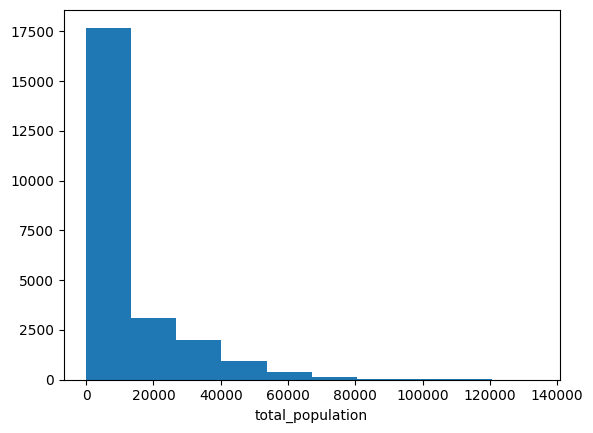

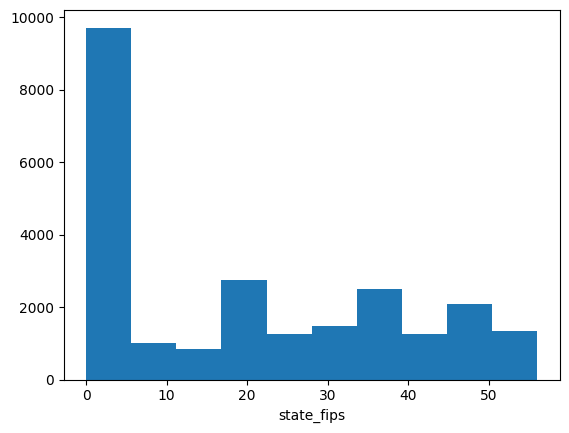

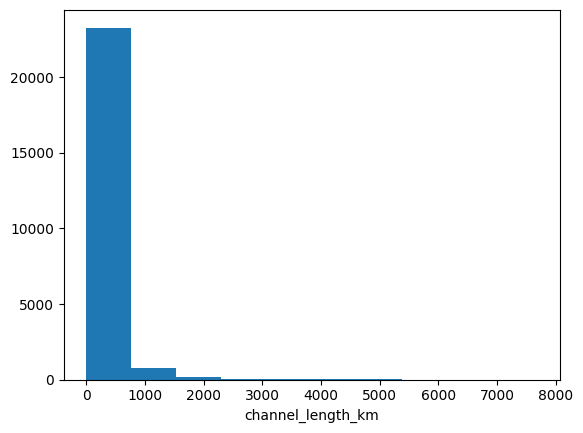

In [34]:
## data is heavily skewer, transform
for col in X_train_fewer.columns:
    f, ax = plt.subplots(1, 1)
    ax.hist(X_train_fewer[col])
    plt.xlabel(col)

Text(0.5, 0, 'median household income')

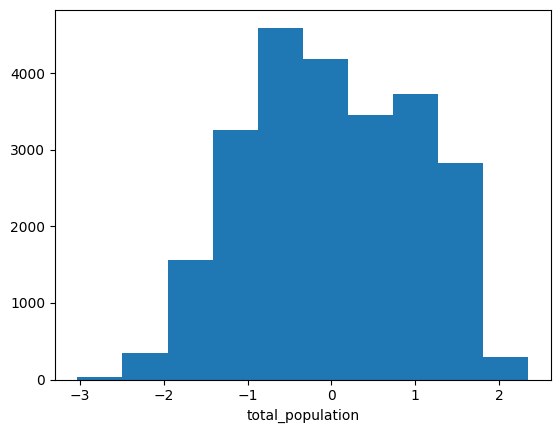

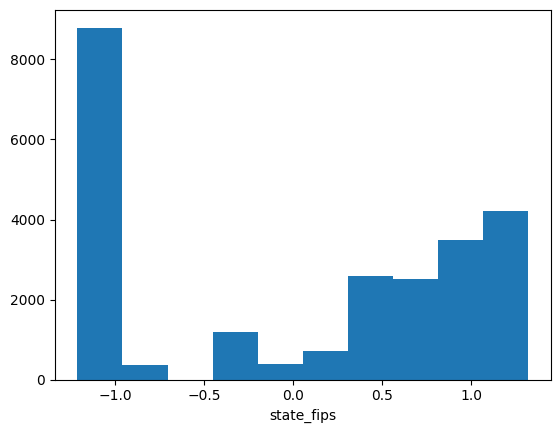

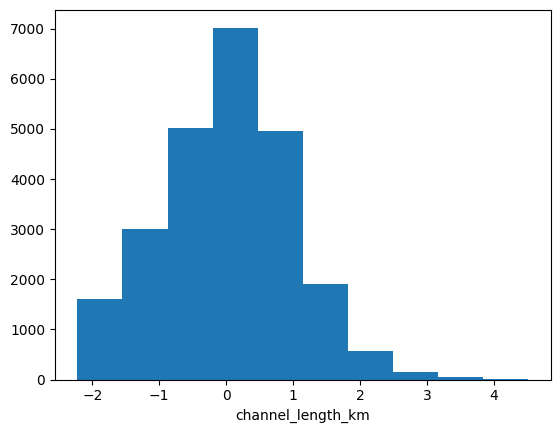

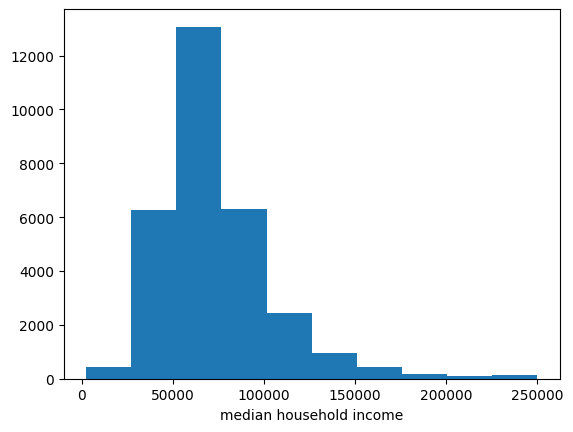

In [36]:
## all the data is heavily skewed, transform
import scipy.stats as ss
from sklearn.preprocessing import PowerTransformer
# transformer = FunctionTransformer(np.log1p, validate=False) # no improvement
transformer = PowerTransformer()
X_train_trans = pd.DataFrame(transformer.fit_transform(X_train_fewer), columns=X_train_fewer.columns)
X_test_trans = transformer.transform(X_test_fewer)


for col in X_train_trans.columns:
    f, ax = plt.subplots(1, 1)
    ax.hist(X_train_trans[col])
    plt.xlabel(col)

f, ax = plt.subplots(1, 1)
ax.hist(y)
plt.xlabel('median household income')

training model score:  0.16763877327677112
test model score:  0.16742725567816052


/opt/miniconda3/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


<Axes: >

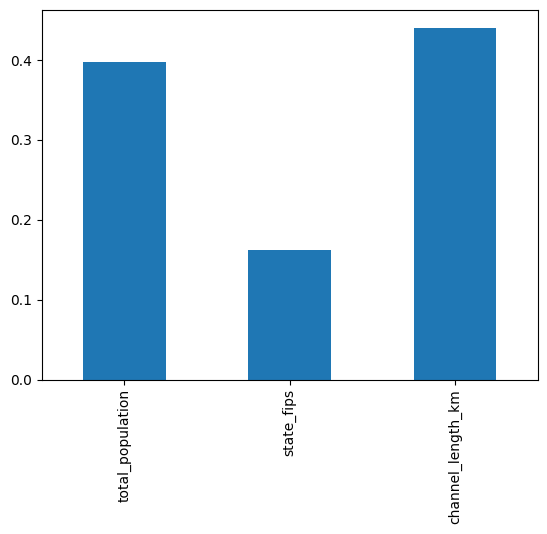

In [38]:
rfr.fit(X_train_trans, np.ravel(y_train))
print('training model score: ', rfr.score(X_train_trans, y_train))
print('test model score: ', rfr.score(X_test_trans, y_test))

importances = rfr.feature_importances_
forest_importances = pd.Series(importances, index=X_train_trans.columns)

fig, ax = plt.subplots()
forest_importances.plot.bar(ax=ax)

### Same result with tranformed data
RFR insensitive to transforms

/opt/miniconda3/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Text(0, 0.5, 'observed')

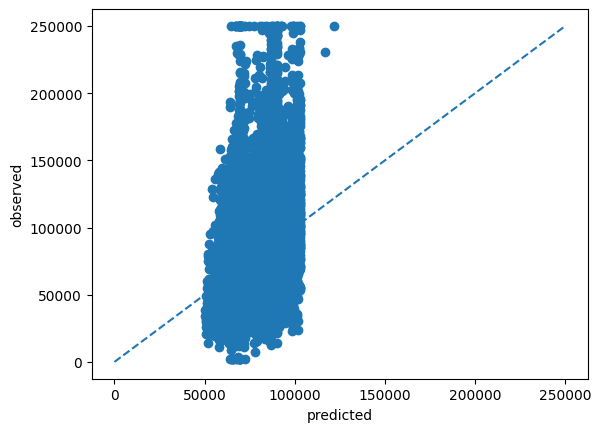

In [49]:
y_pred_test = rfr.predict(X_test_trans)
y_pred_train = rfr.predict(X_train_trans)

f, ax = plt.subplots()
# ax.scatter(y_pred_test, y_test)
ax.scatter(y_pred_train, y_train)

plt.plot([0, 250000], [0, 250000], linestyle='--')
ax.set_xlabel('predicted')
ax.set_ylabel('observed')

## Model underfit higher incomes - very few high income ZCTAs
any specific feature value ranges we're also underpredicting for? 

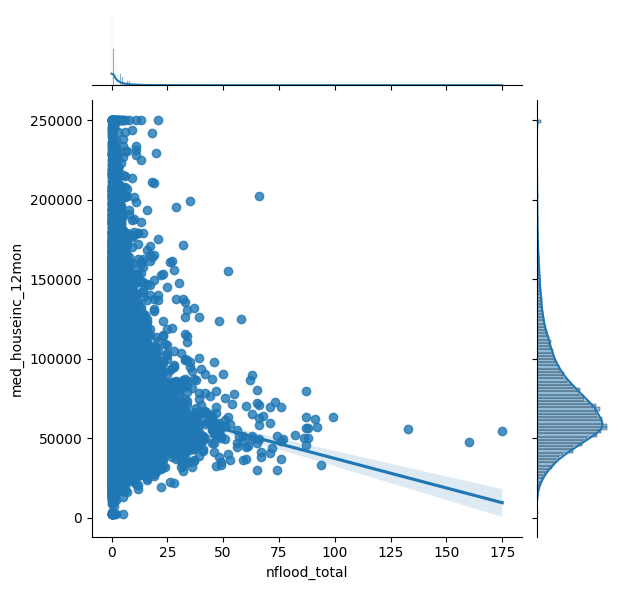

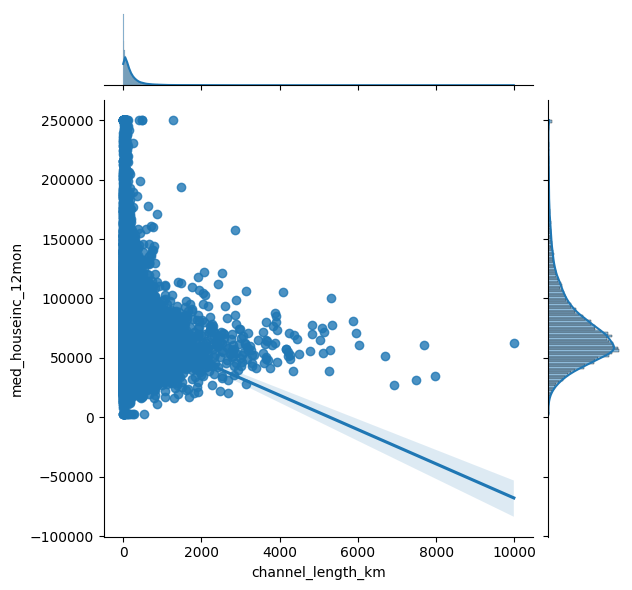

In [48]:
sns.jointplot(data=data_medianinc, x='nflood_total', y=target, kind='reg')
sns.jointplot(data=data_medianinc, x='channel_length_km', y=target, kind='reg')

0.012157754274982703 369
training model score:  0.5198615939269026
test model score:  0.14048905130796796


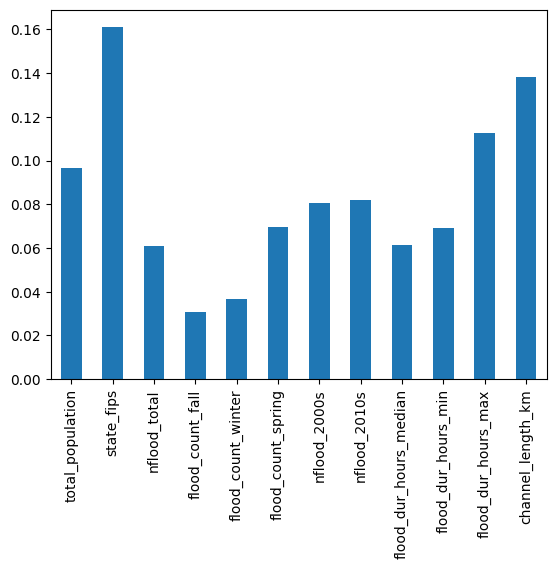

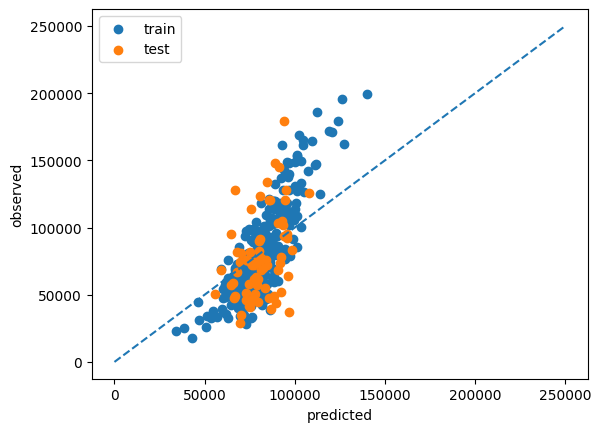

In [63]:
## what is we exclude 
#selected flood cutoff to balance training and test score, minimizing overfitting for training accuracy
data_medianinc_floods_only = data_medianinc.loc[data_medianinc['nflood_total'] > 10, :] 
data_medianinc_floods_only = data_medianinc_floods_only.loc[data_medianinc_floods_only[target] < 200000, :] 
data_medianinc_floods_only = data_medianinc_floods_only.loc[data_medianinc_floods_only['channel_length_km'] < 100, :] 

print(len(data_medianinc_floods_only) / len(data_medianinc), len(data_medianinc_floods_only))
rfr = RandomForestRegressor(max_depth=5, n_estimators=100, random_state=777)

X = data_medianinc_floods_only.drop(target, axis=1)
y = data_medianinc_floods_only[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=777)
X_train = X_train.drop('delta_floods', axis=1)
X_test = X_test.drop('delta_floods', axis=1)
rfr.fit(X_train, y_train)
print('training model score: ', rfr.score(X_train, y_train))
print('test model score: ', rfr.score(X_test, y_test))

y_pred_train = rfr.predict(X_train)
y_pred_test = rfr.predict(X_test)

importances = rfr.feature_importances_
forest_importances = pd.Series(importances, index=X_train.columns)

fig, ax = plt.subplots()
forest_importances.plot.bar(ax=ax)

f, ax = plt.subplots(1, 1)
ax.scatter(y_pred_train, y_train)
ax.scatter(y_pred_test, y_test)
plt.plot([0, 250000], [0, 250000], linestyle='--')
ax.set_xlabel('predicted')
ax.set_ylabel('observed')
ax.legend(['train', 'test'])


In [65]:
#Continue to use transformed data (might help for adaboosting and gradient boosting later)
# Can we improve using different parameters? 
# CV Grid Search for hyperparameter tuning

##RFR
param_grid = {
    'random_state': [777],
    'max_depth': [5, 6, 3],
    'n_estimators': [100, 200, 300, 500], 
    'criterion': ['squared_error'] #absolute error is another criterion but performance is significantly reduced so skipped it
}
rfr = RandomForestRegressor()
grid_search = GridSearchCV(estimator=rfr, param_grid=param_grid, cv=3)
grid_search.fit(X_train, np.ravel(y_train))
print(grid_search.best_params_)

y_pred_rfr = grid_search.predict(X_test)
y_pred_rfr_train = grid_search.predict(X_train)

print('training model score: ', grid_search.score(X_train, y_train))
print('test model score: ', grid_search.score(X_test, y_test))




{'criterion': 'squared_error', 'max_depth': 5, 'n_estimators': 500, 'random_state': 777}
training model score:  0.5390796947053771
test model score:  0.13793543430645772


In [67]:
##Gradient Boost

param_grid = {
    'random_state': [777],
    'learning_rate': [0.5, 2, 1],
    'n_estimators': [100, 200, 300, 500], 
    'loss': ['squared_error', 'huber', 'quantile']
}
gb = GradientBoostingRegressor()
grid_search = GridSearchCV(estimator=gb, param_grid=param_grid, cv=3)
grid_search.fit(X_train, np.ravel(y_train))
print(grid_search.best_params_)

y_pred_gb = grid_search.predict(X_test)

print('training model score: ', grid_search.score(X_train, y_train))
print('test model score: ', grid_search.score(X_test, y_test))

{'learning_rate': 0.5, 'loss': 'huber', 'n_estimators': 100, 'random_state': 777}
training model score:  0.9630553041787521
test model score:  -0.09345269782410748


MSE:  1001174832.5999894


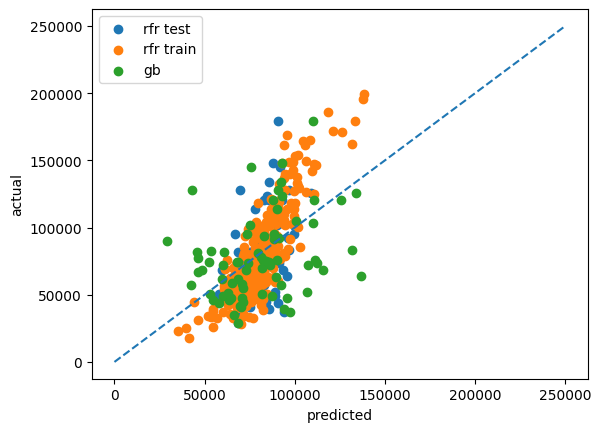

In [68]:
# plt.scatter(y_pred_ada, y_test, label='ada')
plt.scatter(y_pred_rfr, y_test, label='rfr test')
plt.scatter(y_pred_rfr_train, y_train, label='rfr train')

plt.scatter(y_pred_gb, y_test, label='gb')
plt.plot([0, 250000], [0, 250000], linestyle='--')
plt.xlabel('predicted')
plt.ylabel('actual')
plt.legend()

print('MSE: ', mean_squared_error(y_test, y_pred_gb))

In [74]:
## see how the model does without flood parameters...
# X_train_noflooddata = X_train_trans.drop(['flood_count_winter', 'flood_dur_hours_median', 'channel_length_km'], axis=1)

# rfr = RandomForestRegressor(criterion='squared_error', max_depth=6, n_estimators=500, random_state=777)
# rfr.fit(X_train_noflooddata, np.ravel(y_train))
# print('training rfr model score: ', rfr.score(X_train_noflooddata, y_train))

# gb = GradientBoostingRegressor(loss='huber', n_estimators=100, random_state=777, learning_rate=0.5)
# gb.fit(X_train_noflooddata, np.ravel(y_train))
# print('training gb model score: ', gb.score(X_train_noflooddata, y_train))


In [75]:
## pull out data with high error, compare feature histograms

data_medianinc_floods_only['prediction'] = np.nan
data_medianinc_floods_only.loc[y_test.index, 'prediction'] = y_pred_rfr
data_medianinc_floods_only.loc[y_train.index, 'prediction'] = y_pred_rfr_train
data_medianinc_floods_only['error'] = (data_medianinc_floods_only[target] - data_medianinc_floods_only['prediction'])

data_high_error = data_medianinc_floods_only.loc[data_medianinc_floods_only['error'] > 25000, :]
data_medianinc_floods_only.sort_values('error', ascending=False)

,med_houseinc_12mon,total_population,state_fips,nflood_total,flood_count_fall,flood_count_winter,flood_count_spring,nflood_2000s,nflood_2010s,flood_dur_hours_median,flood_dur_hours_min,flood_dur_hours_max,channel_length_km,delta_floods,prediction,error
zcta,,,,,,,,,,,,,,,,
10570,179056.0,13168.0,36,14,1,2,4,2.0,10.0,0.581967,0.262295,4.672131,67.007,0.666667,90529.696728,88526.303272
7675,168662.0,26989.0,34,16,1,0,8,2.0,9.0,1.540984,0.344262,26.803279,47.028,0.636364,95910.633770,72751.366230
19087,161554.0,33683.0,42,13,0,0,3,2.0,7.0,1.967213,0.868852,6.393443,51.414,0.555556,93846.942036,67707.057964
20815,185873.0,31080.0,24,13,3,0,4,0.0,10.0,1.967213,0.950820,3.557377,24.374,1.000000,118325.163405,67547.836595
22181,199197.0,15698.0,51,35,7,2,4,1.0,24.0,1.967213,0.409836,5.901639,29.586,0.920000,138321.688192,60875.311808
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15132,32859.0,19387.0,42,13,0,0,5,0.0,13.0,1.967213,0.000000,5.016393,36.735,1.000000,76649.782203,-43790.782203
39440,38400.0,20459.0,28,33,6,8,8,2.0,28.0,1.803279,0.491803,18.491803,73.869,0.866667,82403.101835,-44003.101835
23504,39611.0,24202.0,51,17,5,0,3,6.0,6.0,1.475410,0.491803,28.442623,6.155,0.000000,85425.707516,-45814.707516


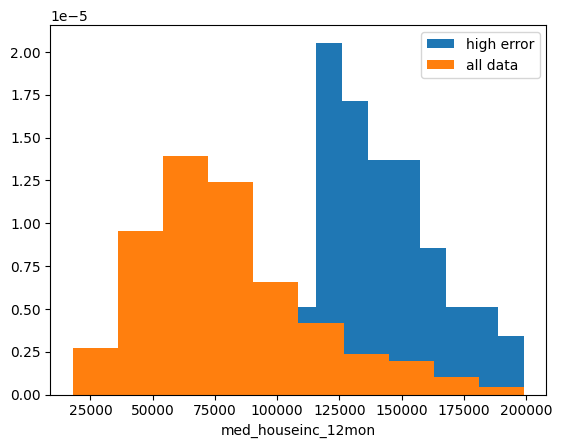

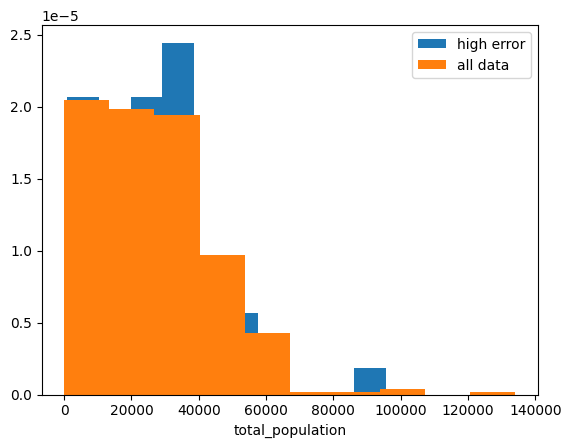

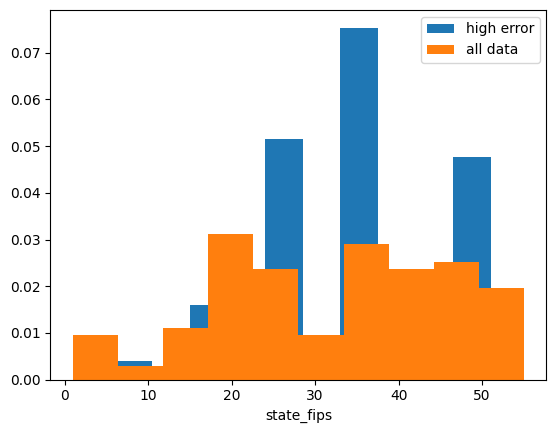

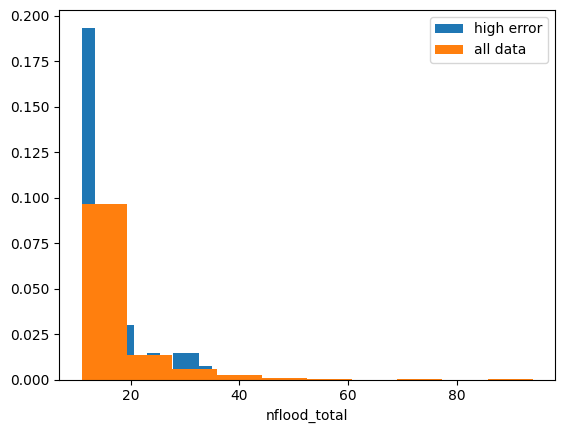

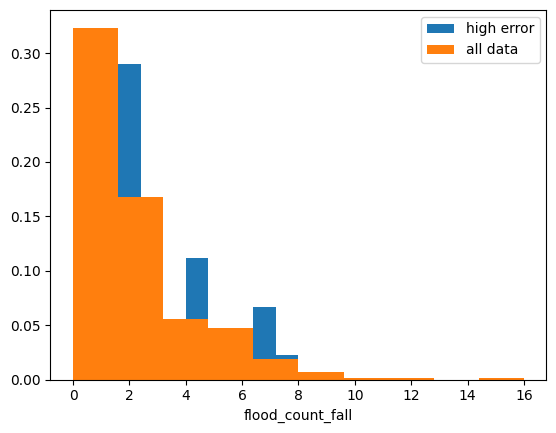

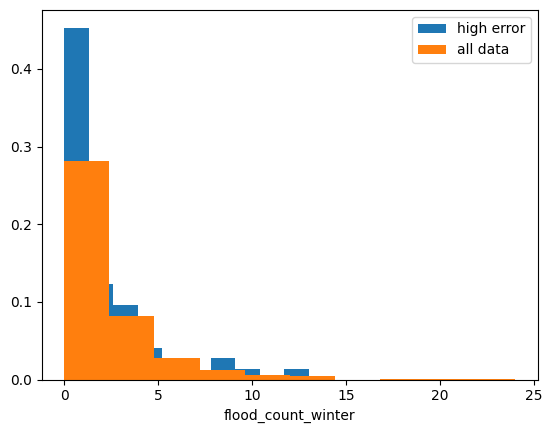

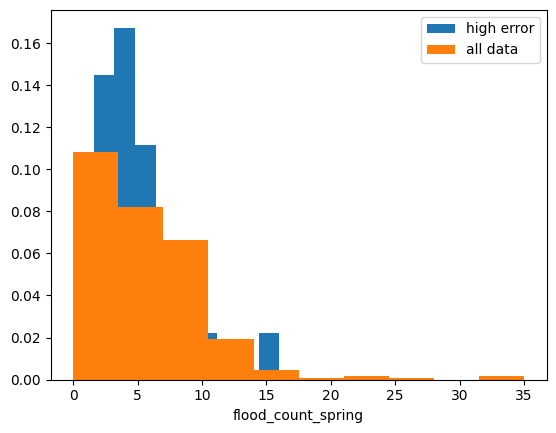

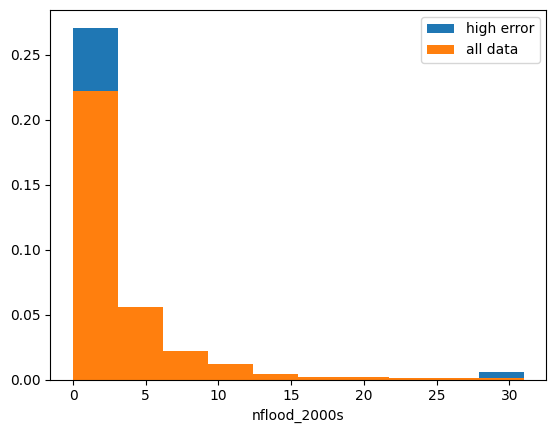

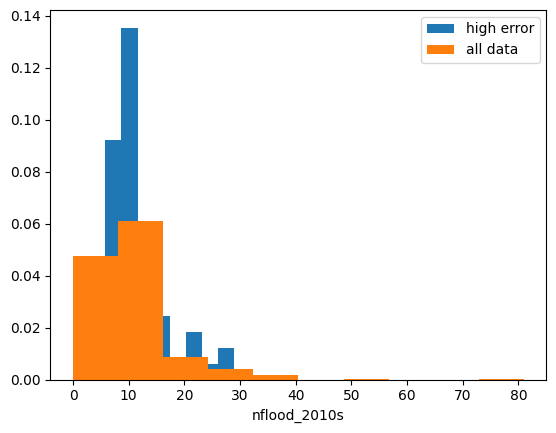

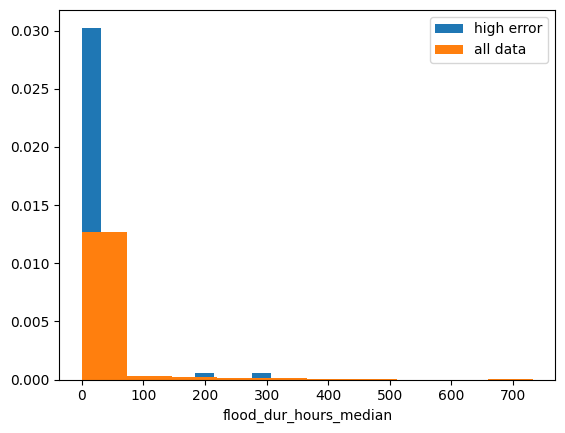

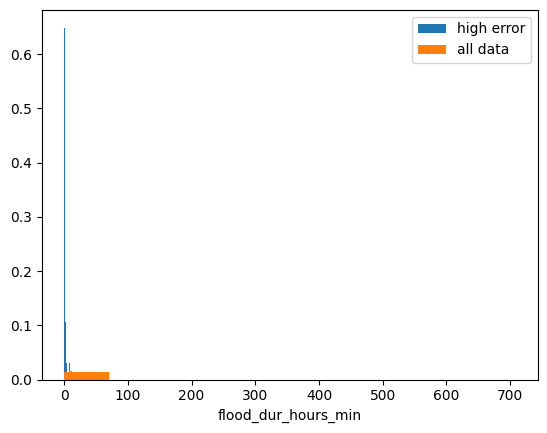

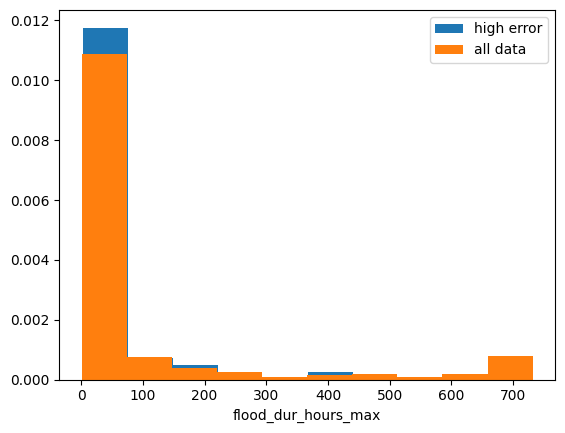

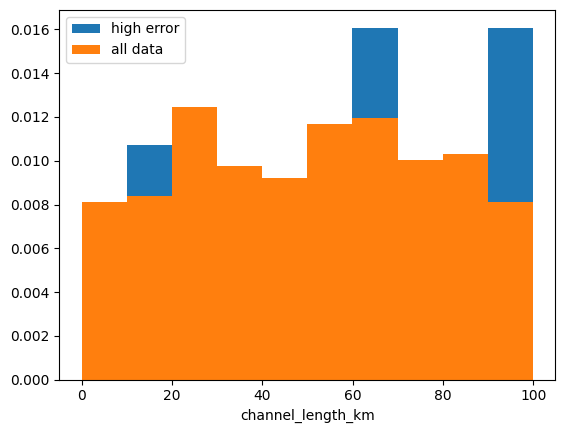

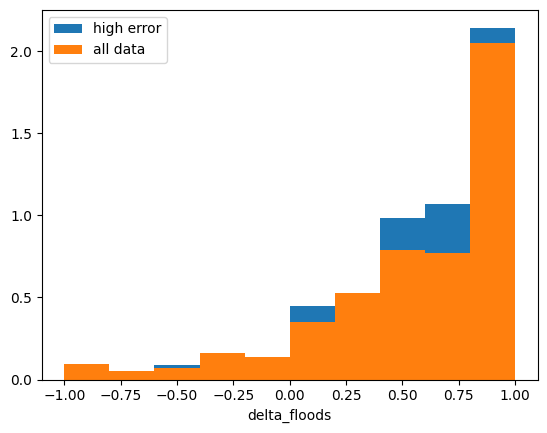

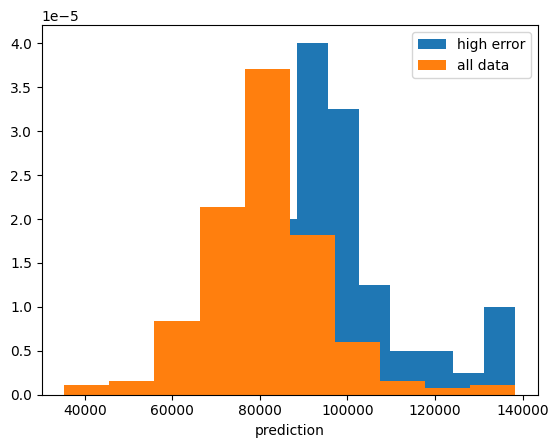

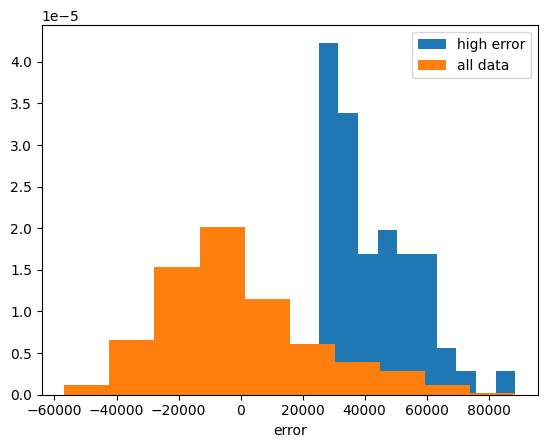

In [73]:
data_high_error

for n in data_high_error.columns:
    f, ax = plt.subplots()
    ax.hist(data_high_error[n], density=True)
    ax.hist(data_medianinc_floods_only[n], density=True)
    ax.legend(['high error', 'all data'])
    ax.set_xlabel(n)



## Summmary of modeling steps taken

#### Split data into train (80%) and test (20%)

#### Predict first Random Forest Regression model
train score: 0.12; test score: 0.11 (Not a great score...)

#### Remove highly correlated features and retrain the model
e.g. delta_floods, flood_dur_min and max, etc.
train score: 0.12; test score: 0.11 same score - good that removing features didn't reduce score so I selected the correct features to remove

#### Address heavily skewed data
Noticed that the data are heavily skewed, with relatively few of the heavily skewed points being very important for the underlying process. For example, only a few zctas have a large number of floods, but all have relatively lower mean household income. 
So - apply Power Transformer to bring the data into a more normal distribution. Despite RFR being relatively insensitive to scaling, the power transform does increase the model score. 
train score: 0.21; test score: 0.21

Another way to reduce the heavily skewed nature of the data is to remove zctas where no floods occurred. Initially, I kept these zctas in because I didn't want to remove wealthy zctas where there was a high incidence of streams but relatively few floods. Removing ZCTAs with zero floods reduces the dataset to 64% of the original to over 19k zctas. Here we actually saw a slight decrease in the test data performance, suggesting that the power law is sufficient to minimize the impact of the skewness. 
train score: 0.21; test score: 0.20

#### Next run grid search cross-validation to select best RFR parameters
If I let max_depth be too large, I get higher training score (>0.4), but the test score is much lower. So, I'll limit max_depth to 6 in the grid search. Best performing RFR, when comparing test/train scores seems to be wide (lots of estimators) and shallow (lower max_depth). 

#### ADABoosting and GradientBoosting Models
Seems like the RFR model doesn't do a great job at predicting the extreme values, so the boosting tree models might help with that. 
AdaBoosting results are very poor... my guess is because ADABoost focuses on the "hard" datapoints, the model overall has a very poor fit. 

The gradientboosting model performs better than the standard rfr model - likely because this model handles outliers slightly better. 

#### Remove the flood metrics
Feature importance plots show that channel length and state is more important for predicting. But by how much? I removed the flood metrics and got almost the same score metrics (reminder, score is R-squared). So, we can say that flood metrics account for very little of the predictive power of mean household income by ZCTA. 

#### Other ideas for model improvement
It's clear that decision trees don't handle outliers (extremely long or frequent floods) very well. Neural networks might perform better. There might also be a way to bootstrap a sample that has more evenly distributed values for large/frequent floods. 



